paper epsilon  ~  0.497 * theta^1.998
tilde epsilon  ~  1.4e-07 * theta^0.996


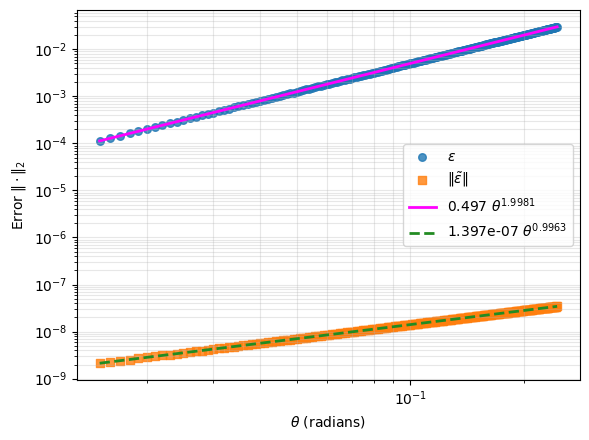

In [ ]:
"""
The plan here will be to numerically implement the results I have between the epsilon shown in the paper
and the epsilon tilde we had defined as the matrix away from symmetry, hopefully proving my theory.
"""

# First we must make A

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr, expm, svd, norm, null_space
from scipy.stats import linregress

n, r        = 100, 20
p = 10 # oversampling factor as in the paper s \geq k
embed = True

rng         = np.random.default_rng(123)

U_A, _      = qr(rng.standard_normal((n, r)), mode='economic')

eps_grid    = np.linspace(0.0, 0.40, 2000)

target_low, target_high = 0.97, 0.9999

sing_vals_A = np.logspace(-7, 2, r)[::-1]

Sigma = np.diag(sing_vals_A)

eps_paper  = []
eps_tilde = []

thetas = np.linspace(1e-3, 5e-1, 500)

theta_kept = [] 

for theta in thetas:
    # z \perpto span(U_A), unit-norm
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= norm(z)

    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)

    # rotate final column toward z
    v0_rot = c * U_A[:, [-1]] + s * z
    V_A[:, [-1]] = v0_rot

    # re-orthonormalise the r columns
    V_A, _ = qr(V_A, mode="economic")

    sigma_min = svd(U_A.T @ V_A, compute_uv=False)[-1]

    #print(sigma_min)
    
    if not (target_low <= sigma_min < target_high):
        continue                              # outside the sigma_min band

    epsilon_paper = 1.0 - sigma_min          # this is the "paper epsilon"

    # make A and approximant A_nyst.
    A        = U_A @ Sigma @ V_A.T

    epsilon_tilde = A - A.T

    epsilon_tilde_norm = norm(epsilon_tilde)

    theta_kept.append(theta)

    eps_paper.append(epsilon_paper)
    eps_tilde.append(epsilon_tilde_norm)

theta_kept = np.array(theta_kept)
eps_paper  = np.array(eps_paper)
eps_tilde  = np.array(eps_tilde)

mask = (theta_kept > 0) & (eps_paper > 0) & (eps_tilde > 0)

theta_kept = theta_kept[mask]
eps_paper  = eps_paper[mask]
eps_tilde  = eps_tilde[mask]

# make sure we're fitting the +ve points
log_th   = np.log10(theta_kept)
log_ep_p = np.log10(eps_paper)
log_ep_t = np.log10(eps_tilde)

# paper epsilon 
res_p = linregress(log_th, log_ep_p)
b_p       = res_p.slope          
loga_p    = res_p.intercept      
a_p       = 10**loga_p

# tilde epsilon 
res_t = linregress(log_th, log_ep_t)
b_t       = res_t.slope        
loga_t    = res_t.intercept
a_t       = 10**loga_t

a_p = 10**loga_p
a_t = 10**loga_t

print(f"paper epsilon  ~  {a_p:.3g} * theta^{b_p:.3f}")
print(f"tilde epsilon  ~  {a_t:.3g} * theta^{b_t:.3f}")

# create smooth fit-lines for the plot
th_fit = np.logspace(np.log10(theta_kept.min()), np.log10(theta_kept.max()), 200)
ep_p_fit = a_p * th_fit**b_p
ep_t_fit = a_t * th_fit**b_t

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.scatter(theta_kept, eps_paper,  marker='o', s=30,
           label=r'$\epsilon$',  alpha=0.8)
ax.scatter(theta_kept, eps_tilde, marker='s', s=30,
           label=r'$\|\tilde{\epsilon}\|$', alpha=0.8)
ax.plot(th_fit, ep_p_fit, '-',  color='magenta', lw=2,
        label=rf'{a_p:.4g} $\theta^{{{b_p:.4f}}}$')
ax.plot(th_fit, ep_t_fit, '--', color='forestgreen', lw=2,
        label=rf'{a_t:.4g} $\theta^{{{b_t:.4f}}}$')
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ (radians)')
ax.set_ylabel(r'Error $\|\cdot\|_2$')
#ax.set_title('epsilon vs theta')
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


paper epsilon  ~  5.09e+03 * theta^1.986
tilde epsilon  ~  6.29e-05 * theta^0.999


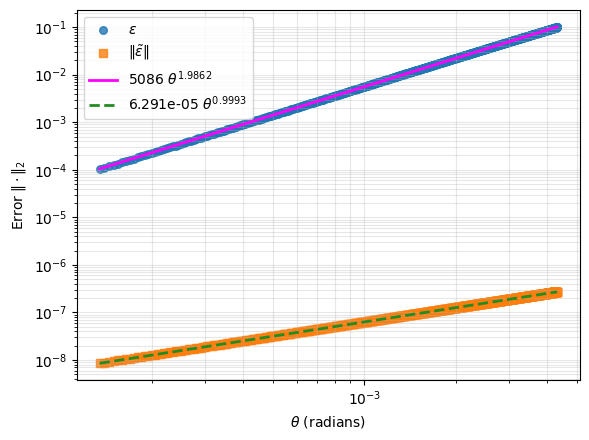

In [8]:
"""
The plan here will be to numerically implement the results I have between the epsilon shown in the paper
and the epsilon tilde we had defined as the matrix away from symmetry, hopefully proving my theory.
"""

# First we must make A

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr, expm, svd, norm, null_space
from scipy.stats import linregress

n, r        = 100, 20
p = 10 # oversampling factor as in the paper s \geq k
embed = True

rng         = np.random.default_rng(123)

U_A, _      = qr(rng.standard_normal((n, r)), mode='economic')

eps_grid    = np.linspace(0.0, 0.40, 2000)

target_low, target_high = 0.90, 0.9999

sing_vals_A = np.logspace(-7, 2, r)[::-1]

Sigma = np.diag(sing_vals_A)

eps_paper  = []
eps_tilde = []

thetas = np.linspace(1e-5, 1e-2, 2000)

theta_kept = [] 

for theta in thetas:
    # z \perpto span(U_A), unit-norm
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= norm(z)

    V_A = U_A.copy()                       # copy the basis we perturb
    sv_max = sing_vals_A[0]                # largest simga_1

    # --- rotate *each* column j by an angle  θ·(σ₁ / σⱼ) --------------------
    for j in range(r):
        scale_theta = theta * (1 / sing_vals_A[j]) * 1e-5
        c, s        = np.cos(scale_theta), np.sin(scale_theta)

        v_rot       = c * U_A[:, [j]] + s * z     # tilted toward z
        V_A[:, [j]] = v_rot                       # overwrite the column
    # re-orthonormalise the r columns
    V_A, _ = qr(V_A, mode="economic")

    sigma_min = svd(U_A.T @ V_A, compute_uv=False)[-1]

    #print(sigma_min)
    
    if not (target_low <= sigma_min < target_high):
        continue                              # outside the sigma_min band

    epsilon_paper = 1.0 - sigma_min          # this is the "paper epsilon"

    # make A and approximant A_nyst.
    A        = U_A @ Sigma @ V_A.T

    #A = A / Sigma[0,0]

    epsilon_tilde = A - A.T

    epsilon_tilde_norm = norm(epsilon_tilde)

    theta_kept.append(theta)

    eps_paper.append(epsilon_paper)
    eps_tilde.append(epsilon_tilde_norm)

theta_kept = np.array(theta_kept)
eps_paper  = np.array(eps_paper)
eps_tilde  = np.array(eps_tilde)

mask = (theta_kept > 0) & (eps_paper > 0) & (eps_tilde > 0)

theta_kept = theta_kept[mask]
eps_paper  = eps_paper[mask]
eps_tilde  = eps_tilde[mask]

# make sure we're fitting the +ve points
log_th   = np.log10(theta_kept)
log_ep_p = np.log10(eps_paper)
log_ep_t = np.log10(eps_tilde)

# paper epsilon 
res_p = linregress(log_th, log_ep_p)
b_p       = res_p.slope          
loga_p    = res_p.intercept      
a_p       = 10**loga_p

# tilde epsilon 
res_t = linregress(log_th, log_ep_t)
b_t       = res_t.slope        
loga_t    = res_t.intercept
a_t       = 10**loga_t

a_p = 10**loga_p
a_t = 10**loga_t

print(f"paper epsilon  ~  {a_p:.3g} * theta^{b_p:.3f}")
print(f"tilde epsilon  ~  {a_t:.3g} * theta^{b_t:.3f}")

# create smooth fit-lines for the plot
th_fit = np.logspace(np.log10(theta_kept.min()), np.log10(theta_kept.max()), 200)
ep_p_fit = a_p * th_fit**b_p
ep_t_fit = a_t * th_fit**b_t

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.scatter(theta_kept, eps_paper,  marker='o', s=30,
           label=r'$\epsilon$',  alpha=0.8)
ax.scatter(theta_kept, eps_tilde, marker='s', s=30,
           label=r'$\|\tilde{\epsilon}\|$', alpha=0.8)
ax.plot(th_fit, ep_p_fit, '-',  color='magenta', lw=2,
        label=rf'{a_p:.4g} $\theta^{{{b_p:.4f}}}$')
ax.plot(th_fit, ep_t_fit, '--', color='forestgreen', lw=2,
        label=rf'{a_t:.4g} $\theta^{{{b_t:.4f}}}$')
ax.legend()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ (radians)')
ax.set_ylabel(r'Error $\|\cdot\|_2$')
#ax.set_title('epsilon vs theta')
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()